In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

# Welcome to CARPoolGP! 

This is an emulator developed in **Zooming by in the CARPoolGP lane: new CAMELS-TNG simulations of zoomed-in massive halos**. The goal of CARPoolGP is to emulate a value of parameter space where we are limited to the number of samples we can obtain at each parameter space location. There is a general structure to CARPoolGP which I will outline below, we can use this as a guide throughout this notebook.

1. Generate a set of parameters, $B$, at which to extract Base sample quantities $\tilde{Q}$.
2. Generate a set $S$ of Parameter Islands, $\theta_{S}$ at which to extract Surrogate sample quantities, $\tilde{Q}^S$. Ensure that Base-Surrogate pairs have some level of correlation between them. 
3. Determine the noise kernels and associated hyperparameters for Base, Surrogate, and Combined quantities: $C_{ij}$, $D_{ij}$, $X_{ij}$.
4. Maximize the likelihood function to obtain the optimal set of hyperparameters: $\hat{\tau}$.
5. Emulate to find $ Q(\theta_{p, i}^\ast)$, and $\sigma^2(\theta_{p, i}^\ast, \theta_{p,j}^\ast)$.

# A Toy model to get started

Before even starting with CARPoolGP we need to outline some of the preliminary information... like the model that we are going to use. In practice we are not lucky enough to know the model, otherwise that would defeat the whole purpose... But here as a toy example to get us started we can make this simple. 

We consider some mean quantity, $ Q$, which has a functional form, 

\begin{equation}
\begin{split}
    Q(\theta_{i}) &= a \theta_{i} + b\theta_{i}^3\sin(\theta_{i})\\
    \tilde{Q}(\theta_{i}) &=  Q(\theta_{i})  + \epsilon,
\end{split}
\end{equation}

Where a and b are some constants, and $\theta_i$ is our independent parameter, and $\epsilon$ is gaussian noise where we take $\epsilon$ to have $\langle\epsilon\rangle=0$ and $\langle\epsilon^2\rangle=\sigma_Q^2(\theta_{i})$. We choose the dimensionality of our parameter to be 1. We define this model below

In [2]:
def get_Q(theta, A=-0.02, B=0.19):
    """
    This is the model which we ultimitely want to predict, represents the 
    smooth variation on some function. 
    """
    return (A * theta  +  theta**3*B**4 * np.sin(theta))

We need to define some global variables that we will use through out the toy model as well. 

In [3]:
sigma_Q  = 0.1       # jitter ontop of smooth variation
N        =50         # Number of Base data samples
Domain   = [-10,10]  # Domain of parameters
LR       = 1e-2      # Optimization learning rate 
ITERS    = 5000      # maximum no of iteration

Lets make a set of "True" values that we can test our emulator against in the future. This will also show us how the functoin moves through spae

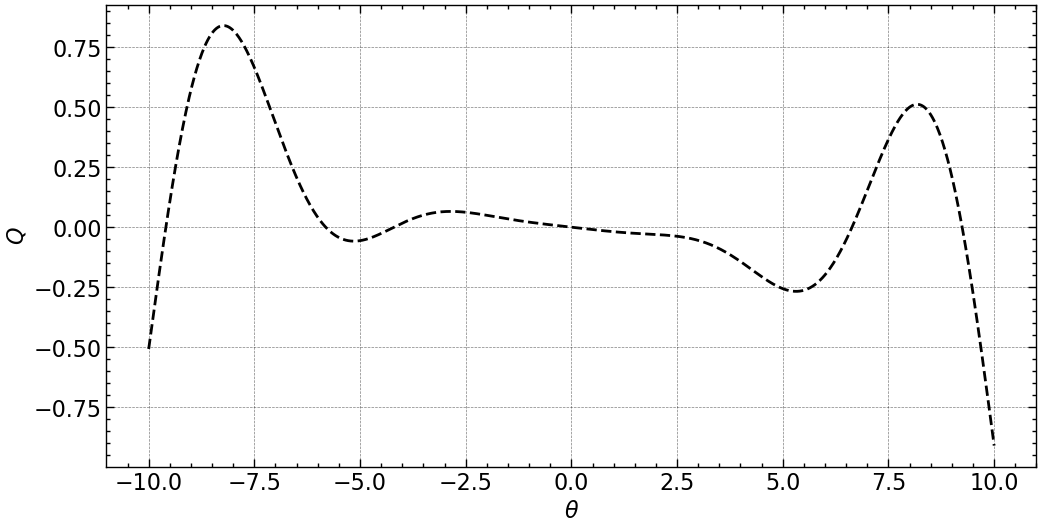

In [4]:
# underlying truth: 
plt.figure(figsize=(12, 6))
theta=np.linspace(*np.array(Domain)+0.001, 1001, endpoint=True)
Y = get_Q(theta) 
plt.plot(theta, Y, 'k--', label='Truth')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$Q$');


## 1. Generate a set of parameters, $B$, at which to extract Base sample quantities $\tilde{Q}$

We build the Base quantities by sampling a uniformly random distribution within the domain $[-10, 10]$ to generate a set of parameters $B\equiv\{{\bf \theta}_{i}| i=1, 2, ..., N\}$, and quantities, $\tilde{Q}({\theta}_i)$. We choose $N=50$ and draw $\epsilon_{Q,i}$ from a normal distribution with $\langle\epsilon_{Q}\rangle = 0$ and $\langle\epsilon_Q^2\rangle = \sigma_Q^2$. 

In [5]:
def model_data(theta, seed=1993, noise=None):
    """
    Args:
        theta (array) : the set of parameters B
        noise (array)  : an array of noise values to add to the raw Q
        seed (int) : seed used to generate random numbers

    Returns:
        \tilde{Q}: noisey data
        noise : noise added to data. 
    """
    Q = get_Q(theta)
    if noise is not None:
        return Q + noise
    np.random.seed(seed)
    noise = np.random.normal(0, sigma_Q, len(theta))
    return Q+noise, noise

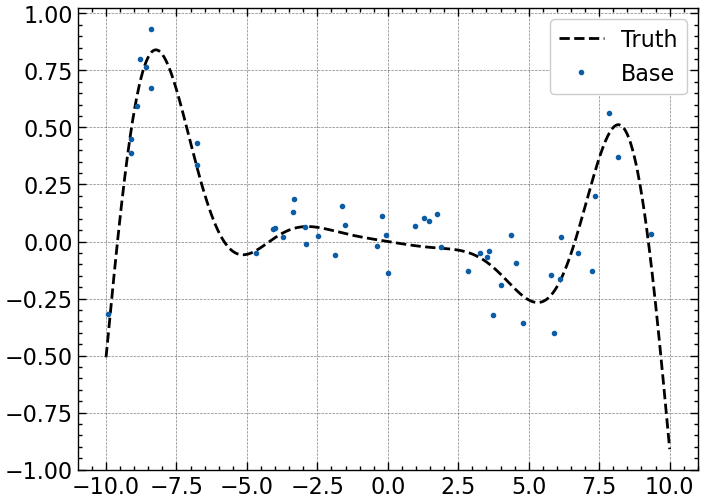

In [6]:
# Sample Data
np.random.seed(194)
theta_B = np.random.uniform(Domain[0], Domain[1], N)
Q_B, intrinsic_noise = model_data(theta_B, 194, None)
plt.plot(theta, Y, 'k--', label='Truth')
plt.plot(theta_B, Q_B, '.', label='Base')
plt.legend();


## 2. Generate a set $S$ of Parameter Islands, $\theta_{S}$ at which to extract Surrogate sample quantities, $\tilde{Q}^S$. Ensure that Base-Surrogate pairs have some level of correlation between them. 


We then generate parameter islands in the set $S\equiv\{\theta_{i}| i=1, 2, ..., N_S\}$ by linearly spacing $N_S=5$ points in the range $[-8, 8]$ with the same process as defined above. For each base sample, the island closest to the parameter is identified, and a surrogate sample is drawn at this island location, $\theta_i$, to generate $\tilde{Q}^S(\theta_i)$ where the noise, $\epsilon_s$, is perfectly correlated with the noise of the base simulation (i.e., the same amplitude of the noise is used $\epsilon_{s, i} = \epsilon{i}$).

In [7]:
def match_surrogates(theta_Q, intrinsic_noise, Groups, f=0.0):
    """
    Generate the correlated surrogate samples given the set of groups, the set of base samples and the noise

    Args:
        theta_Q (array): base samples
        intrinsic_noise (array): noise associated with tilde{Q}
        Groups (int): number of groups
        f (float: _description_. Defaults to 0.

    Returns:
        theta_S, and S
    """
    Surrogate_locs = np.linspace(-8, 8, Groups, endpoint=True)
    nearest_island = np.zeros_like(theta_Q)
    for i, pi in enumerate(theta_Q):
        nearest_island[i] = Surrogate_locs[np.argmin((pi - Surrogate_locs)**2)]
    S_raw = get_Q(nearest_island)
    S = S_raw + intrinsic_noise*(1-f) + f*np.random.normal(0, sigma_Q, len(S_raw))
    return nearest_island, S

In [8]:
theta_S, Q_S = match_surrogates(theta_B, intrinsic_noise, Groups=5, f=0)

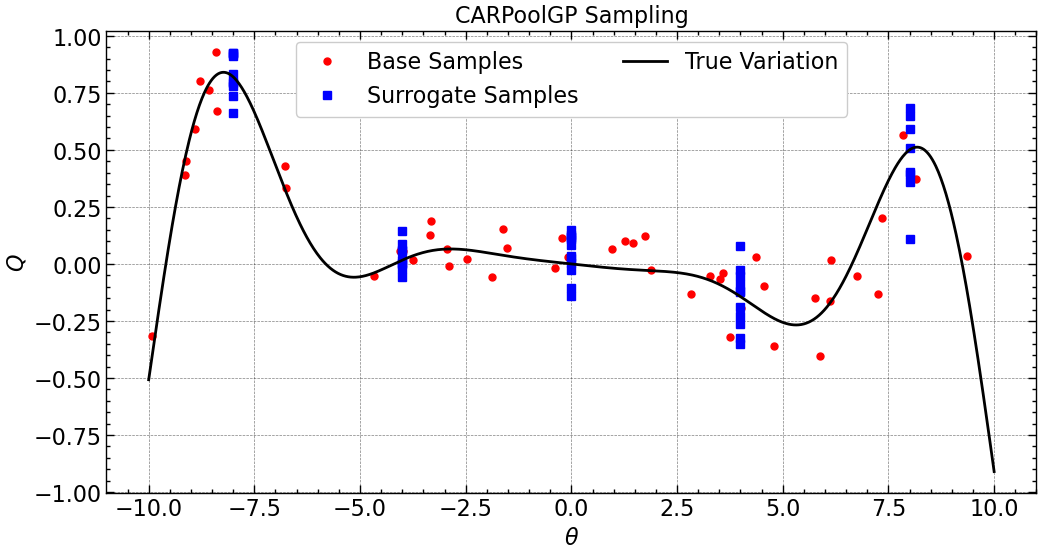

In [9]:
fig, axs = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(12,6), gridspec_kw={'wspace':0.02})
axs.plot(theta_B, Q_B, 'o', color='r', markersize=5, label='Base Samples')
axs.plot(theta_S, Q_S, 's', color='b', label='Surrogate Samples')
axs.plot(theta, Y, 'k', label='True Variation')
axs.set_title('CARPoolGP Sampling')
axs.set_xlabel(r'$\theta$')
axs.set_ylabel('$Q$')
axs.legend(ncol=2, loc='upper center');



## 3. Determine the noise kernels and associated hyperparameters for Base, Surrogate, and Combined quantities: $C_{ij}$, $D_{ij}$, $X_{ij}$.


For both base and surrogate samples, we use a radial basis function defined in Eq.~\ref{eq:rbf} to describe the smooth varying component of the covariance. Base and surrogates are drawn from the same underlying process and with the same level of sample variance, so the hyperparameters, $\bm{\tau}$, are shared across both matrices. 

\begin{equation}
\begin{split}
    V_{ij} = \alpha\exp\left(-\gamma \, d_E(\theta_{i} - \theta_{j})^2\right)\\
    W_{ij} = \alpha\exp\left(-\gamma \, d_E(\theta_{i} - \theta_{j})^2\right).
\end{split}
\end{equation}

The only difference between the two matrices is the parameters that are used to generate them. $V$, uses the base samples, while $W$ uses the surrogate samples. The full covariance for the base samples and the surrogate samples can be written following covariance functions

\begin{equation}
\begin{split}
    C_{ij} &= \alpha\exp\left(-\gamma \, d_E(\theta_{i} - \theta_{j})^2\right) + \sigma_Q^2\mathcal{I}\\
    D_{ij} &= \alpha\exp\left(-\gamma \, d_E(\theta_{i} - \theta_{j})^2\right) + \sigma_Q^2\mathcal{I}.
\end{split}
\end{equation}

We choose the kernel that describes the smooth covariance between the base and surrogate samples to be an RBF, but we set the additional parameter, $\Delta q_{BS} =0$, as the processes between the base and surrogates are the same. We use the same scale and amplitude parameters for the $V_{ij}$ and $W_{ij}$ matrices to define the covariance between base and surrogate samples,

\begin{equation}
    Y_{ij} = \alpha\exp\left(-\gamma \, \left(d_E(\theta_{i}, \theta_{j})^2\right)\right).\\    
\end{equation}

To relate the base samples to the surrogates, we use the fact that we have set a perfect correlation between the sample fluctuations and, therefore, set the $M$ matrix to
\begin{equation}
    M_{ij} = \sigma_Q^2\delta_{ij},
\end{equation}
where the $\delta_{ij}$ is a delta function that is $1$ at locations of base-surrogate pairs, and $0$ elsewhere. Recall that the distance between parameter space locations in $Y_{ij}$ and $M_{ij}$ are evaluated between base and surrogate samples.
Following Eq.~\ref{eq:cov_X}, we then have
\begin{equation}
\begin{split}
    X_{ij} = &\alpha\exp\left(-\gamma \, \left(d_E(\theta_{i} - \theta_{j})^2\right)\right) + \sigma_Q^2.\\
\end{split}
\end{equation}
We can now build the block covariance matrix containing all of these components following Eq.~\ref{eq:sigma} where $\bm{\tau}$ is the vector of hyperparameters, $\bm{\tau}=(\alpha, \gamma, \sigma^2_Q)$

All of these kernels are taken care of internally by CARPoolGP. So what we have to do is define the simulations and surrogates which we can do as follows:

In [10]:
from src import CARPoolSimulations
from src import CARPoolEmulator


# Create simulation objects and surrogate objects
sims = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = theta_B  ;  sims.quantities  = Q_B
surrs.parameters = theta_S  ;  surrs.quantities = Q_S

## 4. Maximize the likelihood function (minimize inverse Wishart function) to obtain the optimal set of hyperparameters: $\hat{\tau}$.

We use the Gaussian likelihood function as defined below and choose uninformative priors for $\mu_B$ and $\mu_S$, but allow them to be learned as additional hyperparameters in the regression. We then minimize the negative log of the likelihood function to obtain an optimal set of hyperparameters, $\hat{\tau}$ using Stochastic Gradient Descent (SGD).

\begin{equation}
\begin{split}
    \mathcal{L}(\tau) = &\frac{1}{(2\pi)^{N/2}} |\Sigma(\tau)|^{-1/2}\,\times \exp\left(-\frac{1}{2}\begin{pmatrix}
        \tilde{Q}-\mu_Q\\
        \tilde{Q}^S-\mu_S
        \end{pmatrix}^T \Sigma(\tau)^{-1}\begin{pmatrix}
        \tilde{Q}-\mu_Q\\
        \tilde{Q}^S-\mu_S
        \end{pmatrix}\right)
\end{split}
\end{equation}

In [11]:
#Build an emulator object (this generates the kernels which you can find in the CARPoolKernels file) 
emu = CARPoolEmulator.Emulator(sims, surrs)

params = {"log_scaleV":3.0, "log_ampV":0.1,
          "log_scaleM":1.0,  "log_jitterV":-1.0, "log_mean":0.0}

# Train the emulator
best_params = emu.train(params, learning_rate=0.01, max_iterations=ITERS)

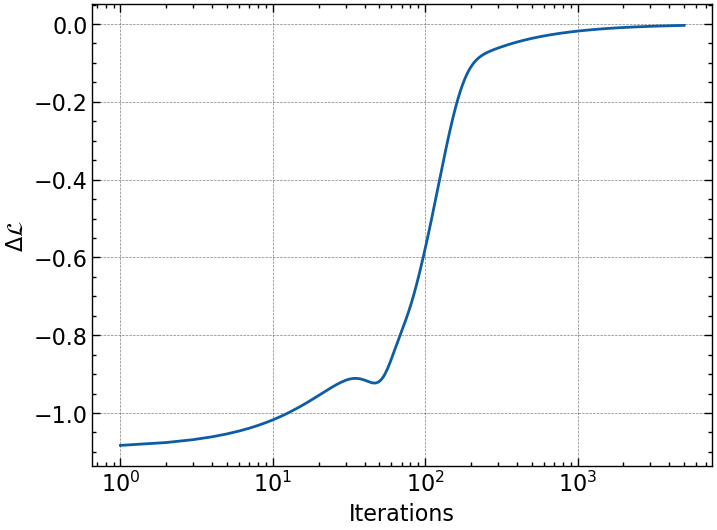

In [12]:
plt.semilogx(np.diff(emu.losses))
plt.xlabel('Iterations')
plt.ylabel(r'$\Delta\mathcal{L}$');

## 5. Emulate to find $ Q(\theta_{p, i}')$, and $\sigma^2(\theta_{p, i}', \theta_{p,j}')$.

We now have all we need to perform an emulation at sample points from the set $T$ using:

\begin{equation}
\begin{split}
     Q(\theta_{p, i}')  & = \text{K}_s(\hat{\tau})\, \Sigma^{-1}_{ij}(\hat{\tau}) \begin{pmatrix}
        \tilde{Q}-\mu_Q\\
        \tilde{Q}^S-\mu_S
        \end{pmatrix} + \begin{pmatrix}
        \mu_Q\\
        \mu_S
        \end{pmatrix}\\
    \sigma^2(\theta_{p, i}', \theta_{p, j}') & = \text{K}_{tt}(\hat{\tau}) - \text{K}_t(\hat{\tau})\Sigma_{ij}^{-1}(\hat{\tau})\text{K}_t^T(\hat{\tau})
\end{split}
\end{equation}


With 

\begin{equation}
    \begin{split}
        \text{K}_t(\hat{\tau}) &= \Sigma(\theta_{p,i}', \theta_{p,j} ; \hat{\tau})\\
        \text{K}_{tt}(\hat{\tau}) &= \begin{pmatrix}
            V(\theta_{p,i}', \theta_{p,j}' ; \hat{\tau}) \,\,\, Y(\theta_{p,i}', \theta_{p,j}' ; \hat{\tau}) \\
            Y^T(\theta_{p,i}', \theta_{p,j}' ; \hat{\tau}) \, W(\theta_{p,i}', \theta_{p,j}' ; \hat{\tau}) 
        \end{pmatrix}\\
    \end{split}
\end{equation}

All of this is taken care by the package

In [13]:
# now emulate! 
pred_mean, pred_var = emu.predict(theta)

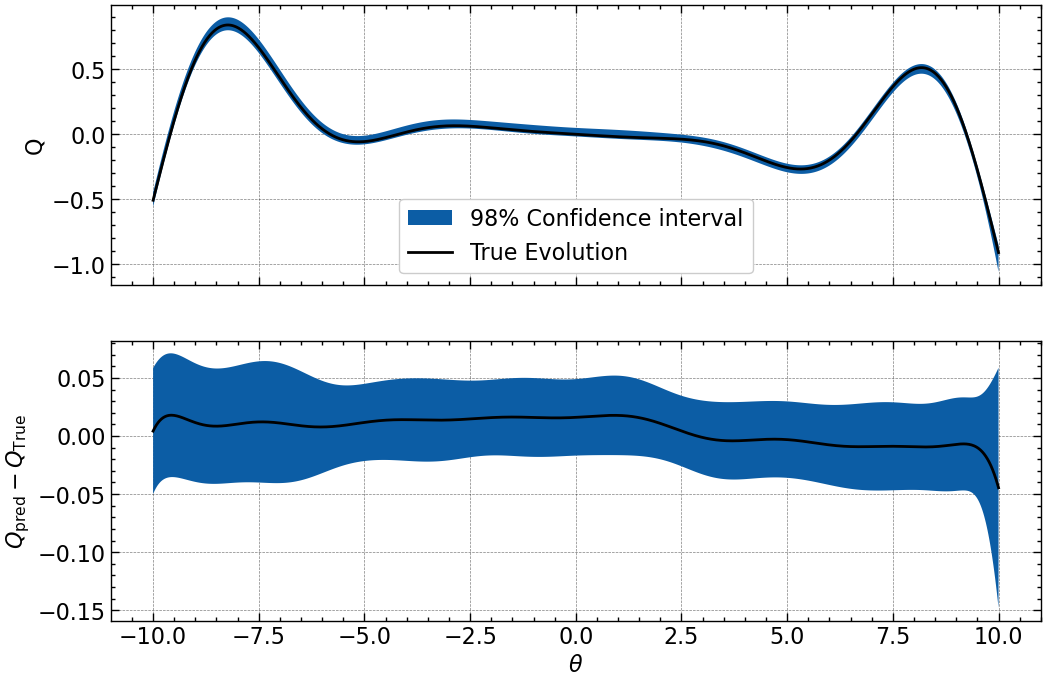

In [14]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
std = np.sqrt(np.diag(pred_var))
axs[0].fill_between(theta, pred_mean - 2*std, pred_mean+2*std, label='98% Confidence interval')
axs[0].plot(theta, Y, 'k', label='True Evolution')

axs[1].fill_between(theta, (pred_mean-Y) - 2*std, (pred_mean-Y)+2*std, label='98% Confidence interval')
axs[1].plot(theta, (pred_mean - Y), 'k', label='Residual')
axs[0].set_ylabel('Q')
axs[1].set_xlabel(r'$\theta$')
axs[1].set_ylabel(r'$Q_{\rm pred} - Q_{\rm True}$')
axs[0].legend();


# Active learning with CARPoolGP

We introduce an active learning method to predict the best next places to sample in parameter space. This is all taken care of in CARPoolGP!

In [15]:
from src import CARPoolEmulator

# Generate an active learning model
model = CARPoolEmulator.ActiveLearning(sims, surrs, theta, Domain[0], Domain[1])

# Initialize the training
best_params = model.train(params, learning_rate=LR, max_iterations=ITERS)

In [36]:
# Run an active learning step to find the next state (Ngrid is for 2**N)
num_new = 10 # Number of new points to sample
Ngrid   = 7  # The number of locations to test at in base 2, (eg, 2^7)
next_thetas, next_surrogates = model.active_learning_step(num_new=10, Ngrid=7, normalize=False)

In [37]:
print('Next base samples:', [i[0] for i in next_thetas])
print('Next surrogate samples:', [i[0] for i in next_surrogates])

Next base samples: [-5.848567672073841, 9.901670515537262, 2.133758831769228, -6.054342966526747, -2.0871826633810997, -5.965835005044937, 2.1017765067517757, -2.064566109329462, -6.006976924836636, 5.986908171325922]
Next surrogate samples: [-4.0, 8.0, 4.0, -8.0, -4.0, -4.0, 4.0, -4.0, -8.0, 4.0]
